In [1]:
import keras
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd 
import os
import tensorflow
from tensorflow.python.client import device_lib
import time
#print(device_lib.list_local_devices())
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
tensorflow.test.is_gpu_available()


Using TensorFlow backend.


True

## Load from keras.datasets.cifar10

In [2]:
train, test = keras.datasets.cifar10.load_data()
x_train, y_train = train[0], train[1]
x_test, y_test = test[0], test[1]

170500096/170498071 [==============================] - 6s 0us/step


## Preprocessing

In [3]:
def preprocessing(x):
    x = x / 255.
    return x.reshape(x.shape[0], -1)

def label_OHE(y):
    return keras.utils.to_categorical(y)

x_train = preprocessing(x_train)
x_test = preprocessing(x_test)
y_train = label_OHE(y_train)
y_test = label_OHE(y_test)
print('train:', x_train.shape, y_train.shape)
print('test:', x_test.shape, y_test.shape)

train: (50000, 3072) (50000, 10)
test: (10000, 3072) (10000, 10)


## Create Model(MLP)
- Add Batch Nomalization Layer befor each DenseLayer

In [4]:
h_list = [512, 256, 128]
drop_list = [0.25, 0.25, 0.25]
def build_mlp(input_shape=x_train.shape[-1:], output_shape=y_train.shape[-1],
              hidden=h_list, reg={'L2':1e-5}, drop = drop_list):
    keras.backend.clear_session()
    
    if list(reg.keys())[0] == 'L2':
        r = keras.regularizers.l2(reg['L2'])
    elif list(reg.keys())[0] == 'L1':
        r = keras.regularizers.l1(reg['L1'])
    else:
        r = keras.regularizers.l1_l2(reg['L1_L2'])
        
    input_layer = keras.layers.Input(input_shape)
    for idx, h in enumerate(hidden):
        if idx == 0:
            x = keras.layers.Dense(units=h, activation='relu', kernel_regularizer=r)(input_layer)
            x = keras.layers.BatchNormalization(axis=-1)(x)
            x = keras.layers.Dropout(drop[idx])(x)
        else:
            x = keras.layers.Dense(units=h, activation='relu', kernel_regularizer=r)(x)
            x = keras.layers.BatchNormalization(axis=-1)(x)
            x = keras.layers.Dropout(drop[idx])(x)
        output_layer = keras.layers.Dense(units=output_shape, activation='softmax')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    return model

model = build_mlp()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

## HyperParameters

In [5]:
EPOCHS = 100
BATCH_SIZE_LIST = [50]
LEARNING_RATE = 1e-3
MOMENTUM = 0.95
#set optimizer
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)#, momentum=MOMENTUM)

## Training (Add Callback)

In [6]:
callback=1
def model_train(model=model, optimizer=optimizer, 
                train = (x_train, y_train), valid = (x_test, y_test),
                e=EPOCHS, bs = BATCH_SIZE_LIST[-1], CALLBACKS= callback):
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train[0], train[1], validation_data=valid, 
              epochs=e, batch_size=bs, shuffle=True, callbacks=CALLBACKS) #add callback "early stop"
    train_loss = model.history.history['loss']
    valid_loss = model.history.history['val_loss']
    train_acc = model.history.history['acc']
    valid_acc = model.history.history['val_acc']
    record = {'train_loss':train_loss,
              'valid_loss':valid_loss,
              'train_acc': train_acc,
              'valid_acc': valid_acc}
    return model, record

## ModelCheckPoint

In [7]:
start = time.time()
model = build_mlp()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpoint = keras.callbacks.ModelCheckpoint(monitor='val_loss',
                                             filepath='cifar10_dnn.h5',
                                             save_best_only=True)
CALLBACKS = [early_stop, checkpoint]
model , record = model_train(model, optimizer, CALLBACKS=CALLBACKS)
duration = time.time() - start
print('{:.0f} mins {:.0f} secs'.format(duration//60, duration%60))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 9s 187us/step - loss: 1.9761 - acc: 0.3184 - val_loss: 1.6749 - val_acc: 0.4041
Epoch 2/100
50000/50000 [==============================] - 8s 154us/step - loss: 1.7301 - acc: 0.3860 - val_loss: 1.6192 - val_acc: 0.4390
Epoch 3/100
50000/50000 [==============================] - 8s 155us/step - loss: 1.6722 - acc: 0.4065 - val_loss: 1.5910 - val_acc: 0.4402
Epoch 4/100
50000/50000 [==============================] - 8s 153us/step - loss: 1.6320 - acc: 0.4204 - val_loss: 1.5317 - val_acc: 0.4643
Epoch 5/100
50000/50000 [==============================] - 8s 156us/step - loss: 1.6117 - acc: 0.4308 - val_loss: 1.4865 - val_acc: 0.4806
Epoch 6/100
50000/50000 [==============================] - 8s 155us/step - loss: 1.6003 - acc: 0.4344 - val_loss: 1.5580 - val_acc: 0.4418
Epoch 7/100
50000/50000 [==============================] - 8s 156us/step - loss: 1.5835 - acc: 0.4408 - val_loss: 1.

## Load Back

In [22]:
model = build_mlp()
model = keras.models.load_model('cifar10_dnn.h5')
loss_loadback, acc_loadbcak = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 90us/step


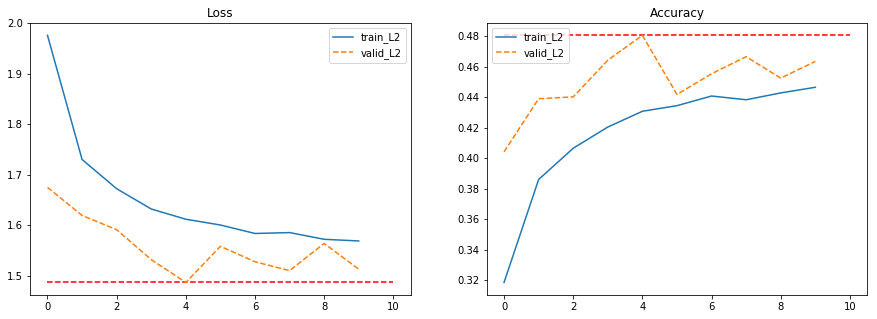

In [23]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
def plot_result(result_, title_, ax1, ax2):
    
    for idx, k in enumerate((result_.keys())):
        if k[-4:] == 'loss':
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'

            ax1.plot(range(len(result_[k])), result_[k], line, label = l)
            ax1.set_title('Loss')
            ax1.legend()
        else:
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'
            ax2.plot(range(len(result_[k])), result_[k], line, label= l)
            ax2.set_title('Accuracy')
            ax2.legend()
        
            
plot_result(record, 'L2', ax1, ax2)
ax1.hlines(y=loss_loadback, xmin=0, xmax=len(record['train_loss']), linestyle='--', color='r')
ax2.hlines(y=acc_loadbcak, xmin=0, xmax=len(record['train_acc']), linestyle='--', color='r')
plt.show()

## Monitor val_acc

In [24]:
start = time.time()
model = build_mlp()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM)
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', patience=5, verbose=1)
checkpoint = keras.callbacks.ModelCheckpoint(monitor='val_acc',
                                             filepath='cifar10_dnn_acc.h5',
                                             save_best_only=True)
CALLBACKS = [early_stop, checkpoint]
model , record = model_train(model, optimizer, CALLBACKS=CALLBACKS)
duration = time.time() - start
print('{:.0f} mins {:.0f} secs'.format(duration//60, duration%60))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 9s 184us/step - loss: 1.9852 - acc: 0.3178 - val_loss: 1.6480 - val_acc: 0.4234
Epoch 2/100
50000/50000 [==============================] - 8s 161us/step - loss: 1.7294 - acc: 0.3869 - val_loss: 1.6277 - val_acc: 0.4274
Epoch 3/100
50000/50000 [==============================] - 8s 162us/step - loss: 1.6685 - acc: 0.4101 - val_loss: 1.5706 - val_acc: 0.4528
Epoch 4/100
50000/50000 [==============================] - 8s 162us/step - loss: 1.6377 - acc: 0.4207 - val_loss: 1.5654 - val_acc: 0.4425
Epoch 5/100
50000/50000 [==============================] - 8s 158us/step - loss: 1.6137 - acc: 0.4290 - val_loss: 1.5140 - val_acc: 0.4674
Epoch 6/100
50000/50000 [==============================] - 8s 161us/step - loss: 1.5944 - acc: 0.4346 - val_loss: 1.5084 - val_acc: 0.4684
Epoch 7/100
50000/50000 [==============================] - 8s 159us/step - loss: 1.5787 - acc: 0.4402 - val_loss: 1.

In [25]:
print(os.listdir(os.getcwd()))

['cifar10_dnn_acc.h5', '__notebook_source__.ipynb', '.ipynb_checkpoints', 'cifar10_dnn.h5']


In [30]:
model = build_mlp()
model = keras.models.load_model('cifar10_dnn_acc.h5')
loss_loadback, acc_loadbcak = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 89us/step


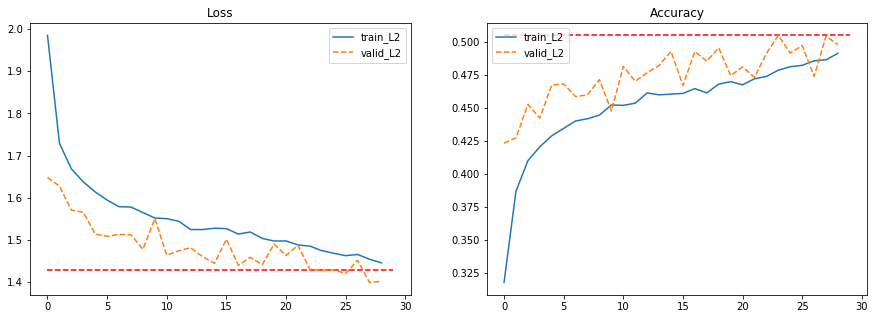

In [31]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
def plot_result(result_, title_, ax1, ax2):
    
    for idx, k in enumerate((result_.keys())):
        if k[-4:] == 'loss':
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'

            ax1.plot(range(len(result_[k])), result_[k], line, label = l)
            ax1.set_title('Loss')
            ax1.legend()
        else:
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'
            ax2.plot(range(len(result_[k])), result_[k], line, label= l)
            ax2.set_title('Accuracy')
            ax2.legend()
        
            
plot_result(record, 'L2', ax1, ax2)
ax1.hlines(y=loss_loadback, xmin=0, xmax=len(record['train_loss']), linestyle='--', color='r')
ax2.hlines(y=acc_loadbcak, xmin=0, xmax=len(record['train_acc']), linestyle='--', color='r')
plt.show()

## save_weight_only

In [32]:
start = time.time()
model = build_mlp()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM)
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', patience=5, verbose=1)
checkpoint = keras.callbacks.ModelCheckpoint(monitor='val_acc',
                                             filepath='cifar10_dnn_acc_weight.h5',
                                             save_best_only=True,
                                             save_weights_only=True)
CALLBACKS = [early_stop, checkpoint]
model , record = model_train(model, optimizer, CALLBACKS=CALLBACKS)
duration = time.time() - start
print('{:.0f} mins {:.0f} secs'.format(duration//60, duration%60))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 9s 181us/step - loss: 2.0053 - acc: 0.3073 - val_loss: 1.6723 - val_acc: 0.4066
Epoch 2/100
50000/50000 [==============================] - 8s 159us/step - loss: 1.7431 - acc: 0.3797 - val_loss: 1.5970 - val_acc: 0.4348
Epoch 3/100
50000/50000 [==============================] - 8s 163us/step - loss: 1.6739 - acc: 0.4047 - val_loss: 1.5609 - val_acc: 0.4444
Epoch 4/100
50000/50000 [==============================] - 8s 159us/step - loss: 1.6388 - acc: 0.4173 - val_loss: 1.5669 - val_acc: 0.4431
Epoch 5/100
50000/50000 [==============================] - 8s 156us/step - loss: 1.6260 - acc: 0.4243 - val_loss: 1.5556 - val_acc: 0.4489
Epoch 6/100
50000/50000 [==============================] - 8s 157us/step - loss: 1.6051 - acc: 0.4289 - val_loss: 1.5074 - val_acc: 0.4623
Epoch 7/100
50000/50000 [==============================] - 8s 155us/step - loss: 1.5911 - acc: 0.4372 - val_loss: 1.

In [36]:
print(os.listdir(os.getcwd()))

['cifar10_dnn_acc.h5', '__notebook_source__.ipynb', '.ipynb_checkpoints', 'cifar10_dnn.h5', 'cifar10_dnn_acc_weight.h5']


In [38]:
model = build_mlp()
model.load_weights('cifar10_dnn_acc_weight.h5')
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
loss_loadback, acc_loadbcak = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 85us/step


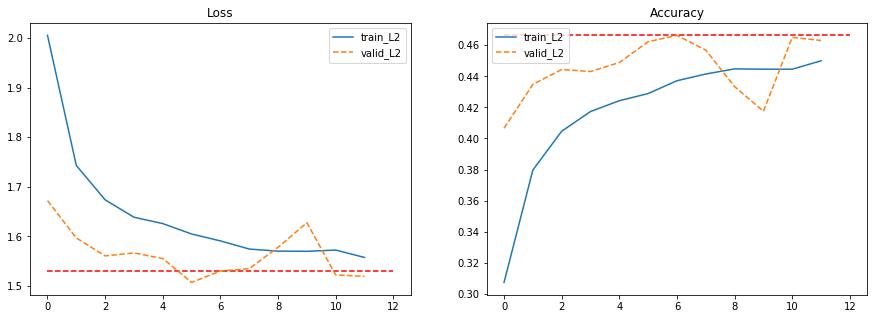

In [39]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
def plot_result(result_, title_, ax1, ax2):
    
    for idx, k in enumerate((result_.keys())):
        if k[-4:] == 'loss':
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'

            ax1.plot(range(len(result_[k])), result_[k], line, label = l)
            ax1.set_title('Loss')
            ax1.legend()
        else:
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'
            ax2.plot(range(len(result_[k])), result_[k], line, label= l)
            ax2.set_title('Accuracy')
            ax2.legend()
        
            
plot_result(record, 'L2', ax1, ax2)
ax1.hlines(y=loss_loadback, xmin=0, xmax=len(record['train_loss']), linestyle='--', color='r')
ax2.hlines(y=acc_loadbcak, xmin=0, xmax=len(record['train_acc']), linestyle='--', color='r')
plt.show()